Multi-scale model: Tumor spheroid growth
======================

In [1]:
from time import time
import tumor2d

%matplotlib inline
import matplotlib.pyplot as plt
from string import capwords

import pyabc


pop_size = 200
min_eps=700
max_nr_pop=100


Model description
--------------------

Briefly, the model is a multi-scale model describing the growth of a 2D tumor spheroid (see animations below). It is a hybrid discrete-continuum model which exploits an agent-based description for individual cells and a PDE-based description for the extracellular matrix. The intra-cellular mechanism of cell-division is described by continuous-time Markov chains and decision rules. In particular the initial phase of the growth is substantially stochastic. During the later phases, with higher cell numbers, averaging effects occur.

The proliferating cells are depicted in orange

![Proliferation](t2danimation/dividing_bg_transparent.gif)

Extracellular matrix intensity is coded in the intensity of the green color

![Extracellular matrix](t2danimation/ecm_bg_transparent.gif)

To simulate a growing spheroid, we employ the simulate function provided by the tumor2d package.

In [2]:
start_time = time()
observation = tumor2d.simulate(division_rate=4.17e-2,
                       initial_spheroid_radius=1.2e1,
                       initial_quiescent_cell_fraction=7.5e-1,
                       division_depth=100,
                       ecm_production_rate=5e-3,
                       ecm_degradation_rate=8e-4,
                       ecm_division_threshold=1e-2)
print(f"Simulation took {time() - start_time:.2f}s")

Simulation took 21.44s


The simulation took a little time.
The simulate function does not return each individual cell.
Instead, we "measure" the radial density of proliferating cells, the radial extracellular matrix density and the spheroid radius over time.
These statistics summarize the underlying data.

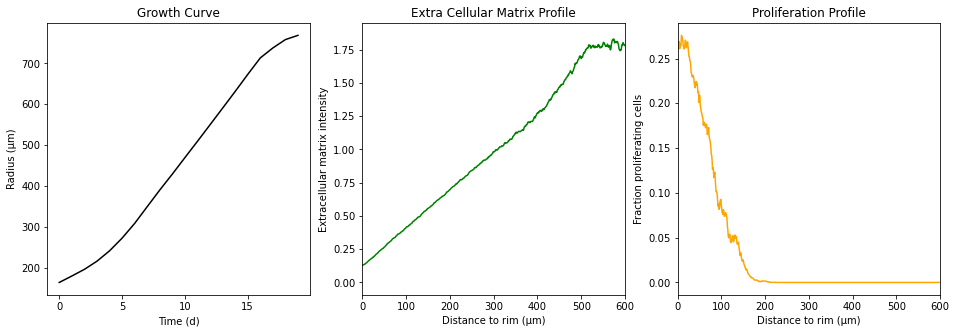

In [3]:
fig, axes = plt.subplots(ncols=3)
fig.set_size_inches((16, 5))

color = {"growth_curve":
             "k",
         "extra_cellular_matrix_profile":
             "green",
         "proliferation_profile":
             "orange"}

x_label = {"growth_curve":
               "Time (d)",
           "extra_cellular_matrix_profile":
               "Distance to rim (μm)",
           "proliferation_profile":
               "Distance to rim (μm)"}

y_label = {"growth_curve":
               "Radius (μm)",
           "extra_cellular_matrix_profile":
               "Extracellular matrix intensity",
           "proliferation_profile":
               "Fraction proliferating cells"}

for ax, (key, val) in zip(axes, observation.items()):
    ax.plot(val, color=color[key])
    ax.set_title(capwords(key.replace("_", " ")))
    ax.set_xlabel(x_label[key])
    ax.set_ylabel(y_label[key])
    if key.endswith("profile"):
        ax.set_xlim(0, 600)

Exemplary pyABC inference run with the model
---------------------------------------------------

To perform parameter inference with pyABC, we first define a prior over the seven parameters.
We do this on the log-domain.

In [4]:
limits = dict(log_division_rate=(-3, -1),
              log_division_depth=(1, 3),
              log_initial_spheroid_radius=(0, 1.2),
              log_initial_quiescent_cell_fraction=(-5, 0),
              log_ecm_production_rate=(-5, 0),
              log_ecm_degradation_rate=(-5, 0),
              log_ecm_division_threshold=(-5, 0))

prior = pyabc.Distribution(**{key: pyabc.RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

data_mean = tumor2d.load_default()[1]  # (raw, mean, var)

Note that we define the ``limits`` dictionary for later visualization usages and then initialize the prior indirectly to not to repeat ourselves.

Each spheroid simulation runs already in its own subprocess, which is forked off from the main process by the simulate function.
We therefore do not need to parallelize using multiprocessing, but will instead use multithreading.
pyABC ships with a flexible sampler which accepts any backend implementing the ``concurrent.futures.Executor`` interface.
For instance, we can use the ``ThreadPoolExecutor``.
For distributed execution the IPython parallel client would be an alternative, but the ``ThreadPoolExecutor`` is good enough for illustrative purposes.

Since we've defined the priors on the log domain, we also use a model accepting log-transformed parameters. This model is defined as ``tumor2d.log_model``.
It is a thin wrapper around the ``tumor2d.simulate`` function and transforms the parameters accordingly before executing the simulate function.

The tumor2d package also provides a distance function and default data.
These data were obtained from 100 samples from the so called "reference parameters", which we also used above to simulate one growing spheroid.
We takte the mean from these 100 simulations as the observed data.
The distance function calculates $L_2$ norms for each of the three summary statistics and adds them up.
(These $L_2$ norms are normalized by the pointwise variances.)

In [6]:
redis_sampler = pyabc.sampler.RedisEvalParallelSampler(host="localhost", port=6379, look_ahead = False)

abc = pyabc.ABCSMC(models=tumor2d.log_model, 
                   parameter_priors=prior,
                   distance_function=tumor2d.distance, 
                   population_size=pop_size, 
                   sampler=redis_sampler)

abc.new("sqlite:////tmp/test.db", data_mean)
history_f = abc.run(max_nr_populations=max_nr_pop_, minimum_epsilon=min_eps)

INFO:History:Start <ABCSMC(id=4, start_time=2020-12-03 17:09:45.849197, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 22465792.59748805
INFO:ABC:t: 0, eps: 22465792.59748805.
INFO:ABC:Acceptance rate: 3 / 10 = 3.0000e-01, ESS=3.0000e+00.
INFO:History:Done <ABCSMC(id=4, start_time=2020-12-03 17:09:45.849197, end_time=2020-12-03 17:10:58.200678)>


Since the inference would run very long on a single local machine, we sample only a single population for illustration purposes.
Note, that we've also set the number of particles to a very small number.
This is much too low for a real inference run, but serves here for illustration purposes and saves sampling time.

We visualize the first populatoin with pyABC's ``plot_kde_matrix`` function.

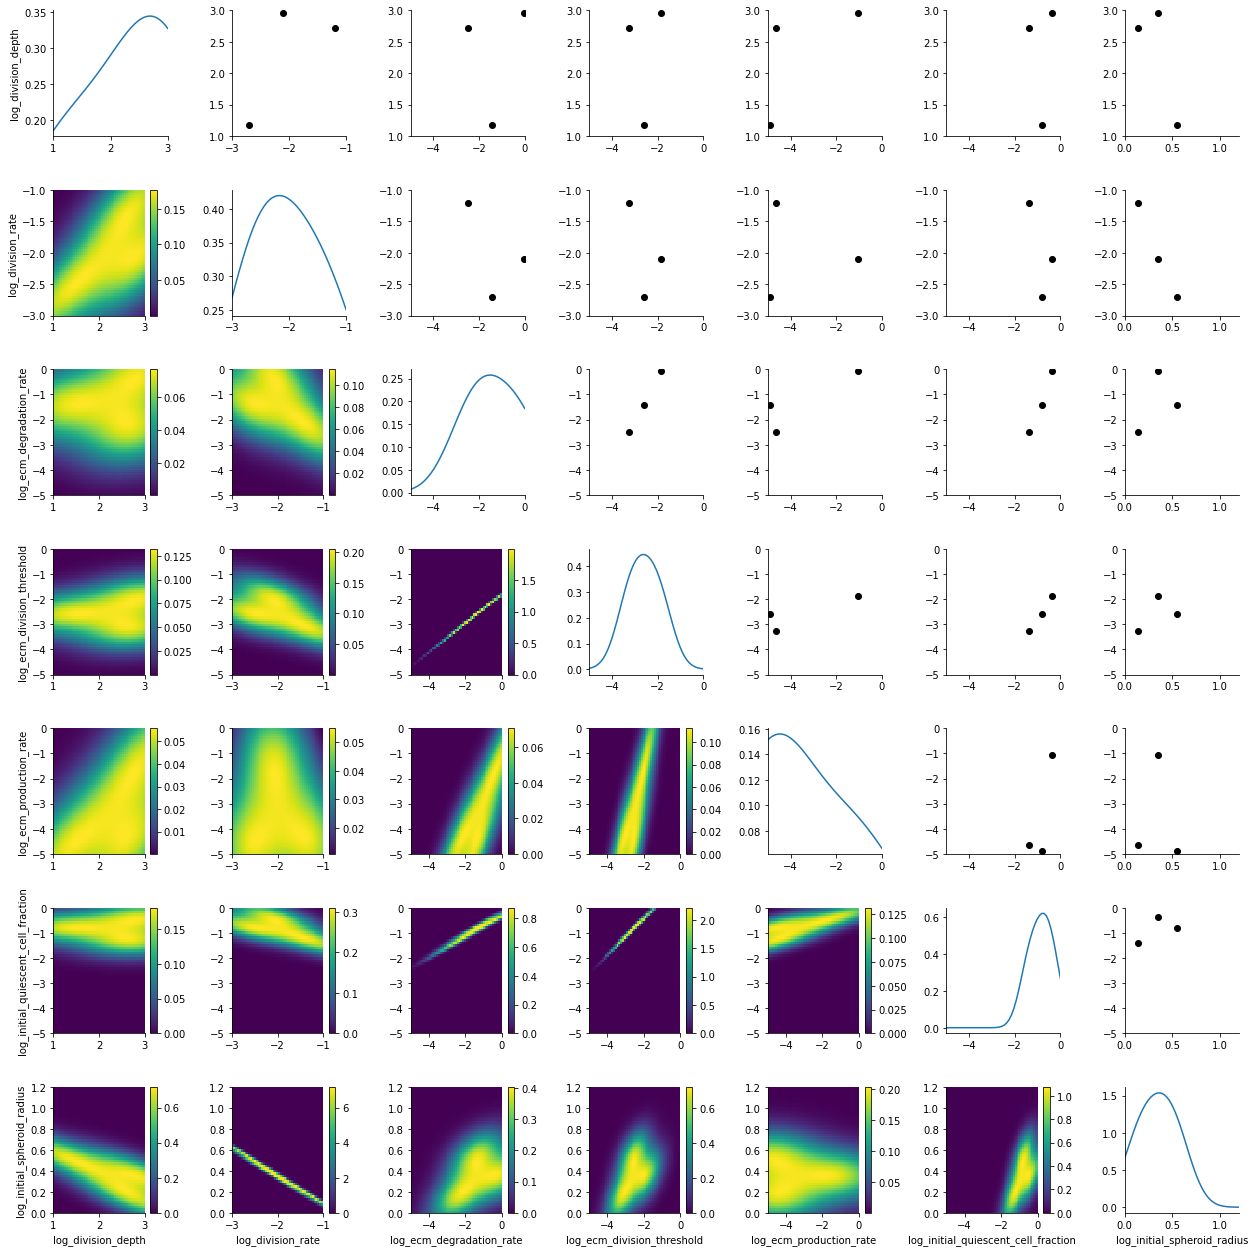

In [7]:
df, w = history_f.get_distribution(m=0,t=history.max_t)
pyabc.visualization.plot_kde_matrix(df, w, limits=limits);

We see kernel density estimates on the lower diagonal and scatter plots of the weighted particles on the upper diagonal.
Note that the weight of the particles is not encoded in the scatter plots.
On the diagonal we see the marginal distributions.

Same thing with new look_ahead=true mode.

In [8]:
redis_sampler = pyabc.sampler.RedisEvalParallelSampler(host="localhost", port=6379, look_ahead = True)

abc = pyabc.ABCSMC(tumor2d.log_model, 
                   prior, 
                   tumor2d.distance, 
                   population_size=pop_size, 
                   sampler=redis_sampler)

abc.new("sqlite:////tmp/test.db", data_mean)
history = abc.run(max_nr_populations=max_nr_pop, minimum_epsilon=min_eps)

INFO:History:Start <ABCSMC(id=5, start_time=2020-12-03 17:12:06.161818, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 22824400.204248413
INFO:ABC:t: 0, eps: 22824400.204248413.
INFO:ABC:Acceptance rate: 3 / 13 = 2.3077e-01, ESS=3.0000e+00.
INFO:History:Done <ABCSMC(id=5, start_time=2020-12-03 17:12:06.161818, end_time=2020-12-03 17:13:24.337007)>


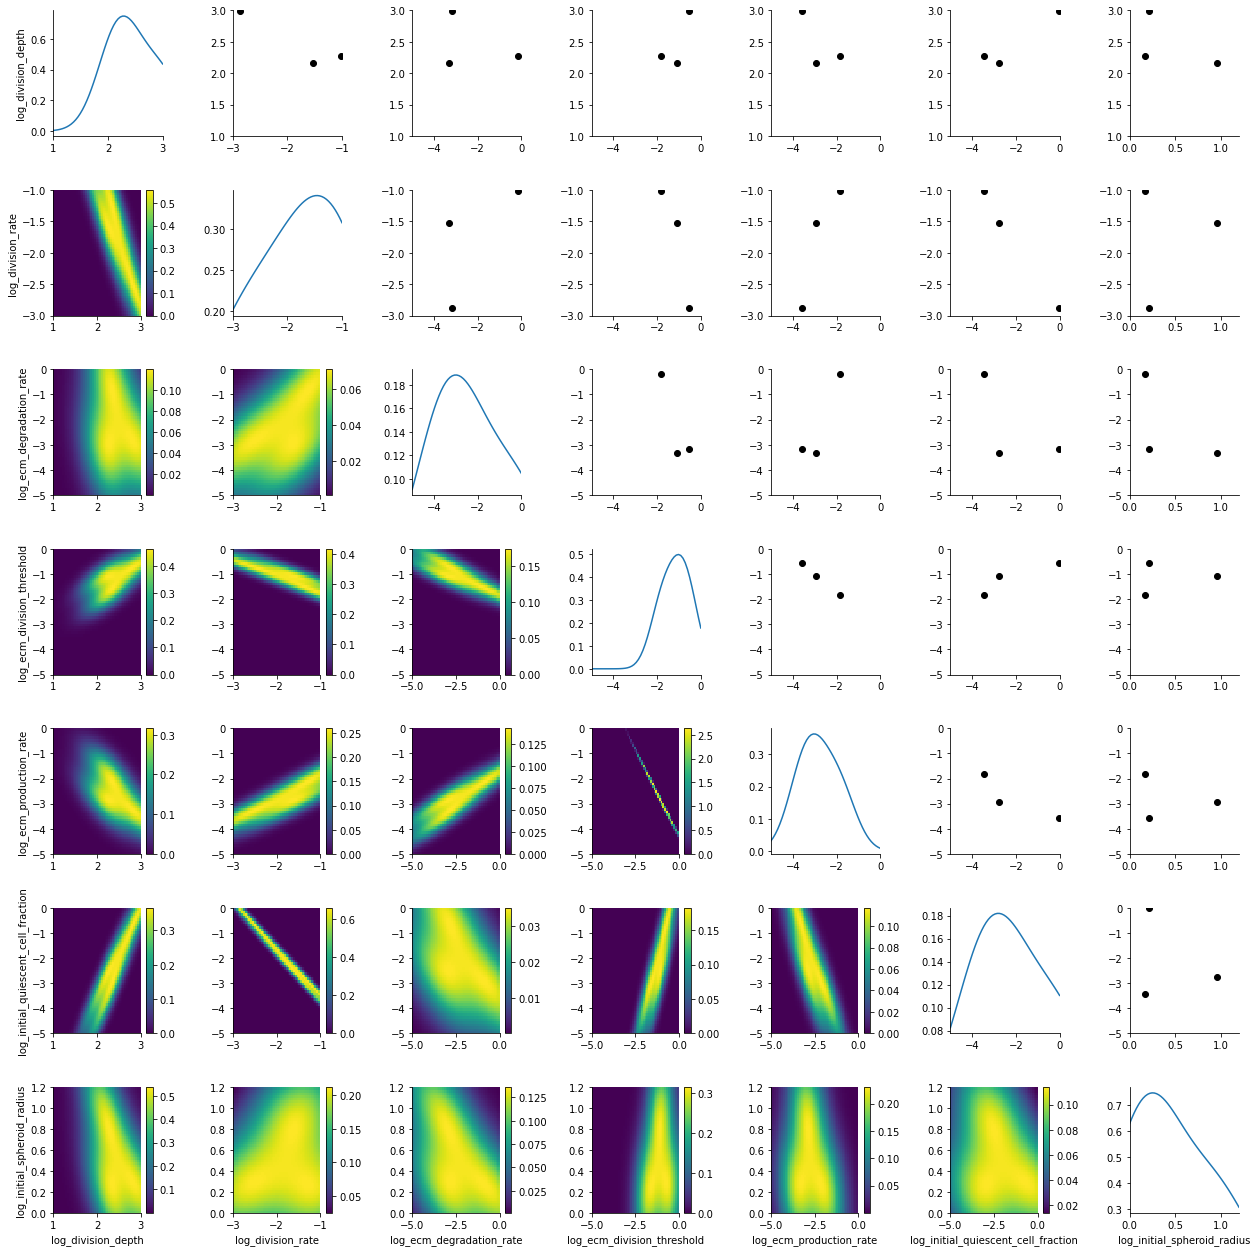

In [10]:
df, w = history.get_distribution(m=0, t=history.max_t)
pyabc.visualization.plot_kde_matrix(df, w, limits=limits);